In [1]:
import os, sys
# Path of the folder containing the buffer client                                              
try:
    pydir=os.path.dirname(__file__)
except:
    pydir=os.getcwd()

sigProcPath = '../../python/signalProc'
sys.path.append(os.path.join(os.path.abspath(pydir),sigProcPath))
import bufhelp
import preproc
import linear
plottingPath= '../../python/plotting'
sys.path.append(os.path.join(os.path.abspath(pydir),plottingPath))
from image3d import *
from scipy.io import loadmat
%pdb
%matplotlib inline
%load_ext autoreload
%autoreload 2

Automatic pdb calling has been turned ON


In [2]:
#load the datafile, and extract the variables                                                  
data=loadmat('ERPdata.mat')
X     =data['X']; print("X= [channels x timepoints x trials]");print(X.shape)
Y     =data['Y'].reshape(-1); print("Y=[trials]");print(Y.shape)
fs    =data['fs'][0]
Cnames=data['Cnames'].reshape(-1); 
Cnames=np.array([item for sublist in Cnames for item in sublist]) #flatten the list of lists of names and make array
print("Channel names : ");print(Cnames)
Cpos  =data['Cpos']; print("Cpos= [ 3 x channels]");print(Cpos.shape);

X= [channels x timepoints x trials]
(64, 76, 300)
Y=[trials]
(300,)
Channel names : 
['FP1' 'AF7' 'AF3' 'F1' 'F3' 'F5' 'F7' 'FT7' 'FC5' 'FC3' 'FC1' 'C1' 'C3'
 'C5' 'T7' 'TP7' 'CP5' 'CP3' 'CP1' 'P1' 'P3' 'P5' 'P7' 'P9' 'PO7' 'PO3'
 'O1' 'Iz' 'Oz' 'POz' 'Pz' 'CPz' 'FPz' 'FP2' 'AF8' 'AF4' 'AFz' 'Fz' 'F2'
 'F4' 'F6' 'F8' 'FT8' 'FC6' 'FC4' 'FC2' 'FCz' 'Cz' 'C2' 'C4' 'C6' 'T8'
 'TP8' 'CP6' 'CP4' 'CP2' 'P2' 'P4' 'P6' 'P8' 'P10' 'PO8' 'PO4' 'O2']
Cpos= [ 3 x channels]
(2, 64)


/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


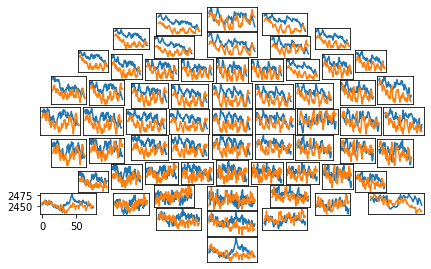

In [3]:
# plot the data                                                                                
image3d(X[:,:,1:3],0,plotpos=Cpos);

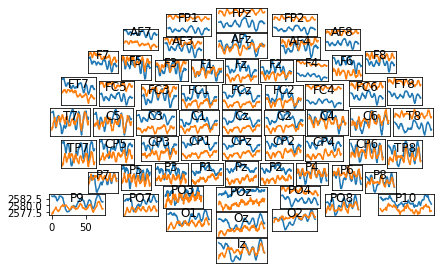

In [4]:
# plot the class averages
erp=np.stack((X[:,:,Y>0].mean(2),X[:,:,Y<=0].mean(2)),2) #compute the ERP
image3d(erp,0,plotpos=Cpos,xvals=Cnames); # plot the ERPs


In [5]:
# define some utility functions to simplify plotting of data
ylabel='time (s)'
yvals =range(0,X.shape[1])/fs  # element labels for 2nd dim of X

def plotTrials(X,trls):
    'Plot the single-trial data'
    global Cnames, Cpos, ylabel, yvals
    image3d(X[:,:,1:3],0,plotpos=Cpos,xvals=Cnames,ylabel=ylabel,yvals=yvals)

def plotERP(X,Y):
    'plot the class averages'
    global Cnames, Cpos, ylabel, yvals
    erp=np.stack((X[:,:,Y>0].mean(2),X[:,:,Y<=0].mean(2)),2) #compute the ERP
    image3d(erp,0,plotpos=Cpos,xvals=Cnames,ylabel=ylabel,yvals=yvals) # plot the ERPs

def updatePlots():
    global X,Y
    # Plot the raw data
    fig=plt.figure(1,figsize=(12, 12))
    plotTrials(X,range(3)) # single trial

    fig=plt.figure(2,figsize=(12, 12))
    plotERP(X,Y) # class averages

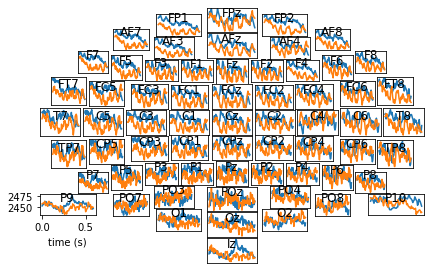

In [6]:
# plot a subset of single-trials
plotTrials(X,range(3));

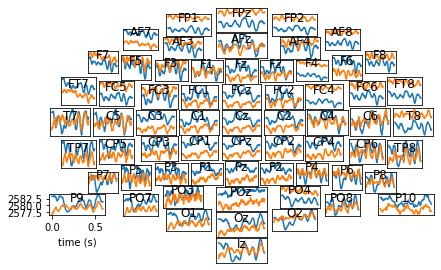

In [7]:
# plot the grand average's per condition
plotERP(X,Y);

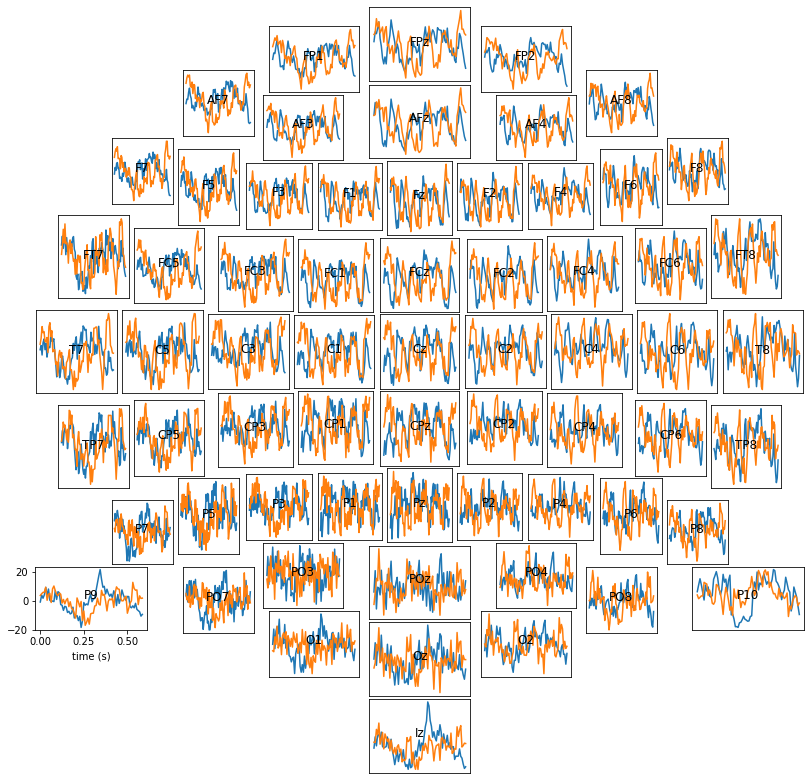

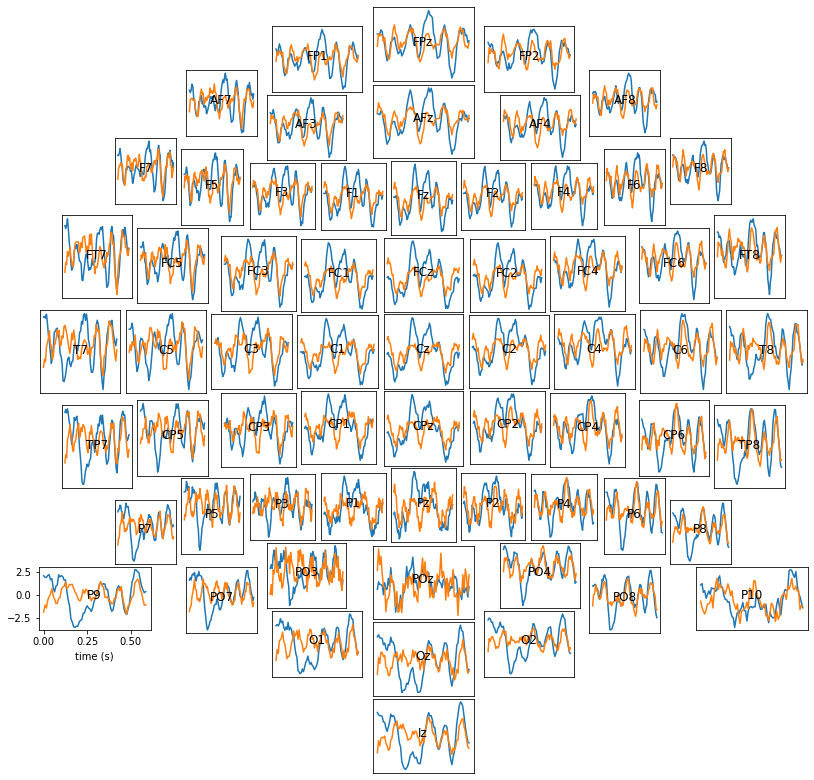

In [8]:
#-------------------------------------------------------------------
#  Run the standard pre-processing and analysis pipeline
# 1: detrend
X        = preproc.detrend(X)
updatePlots();

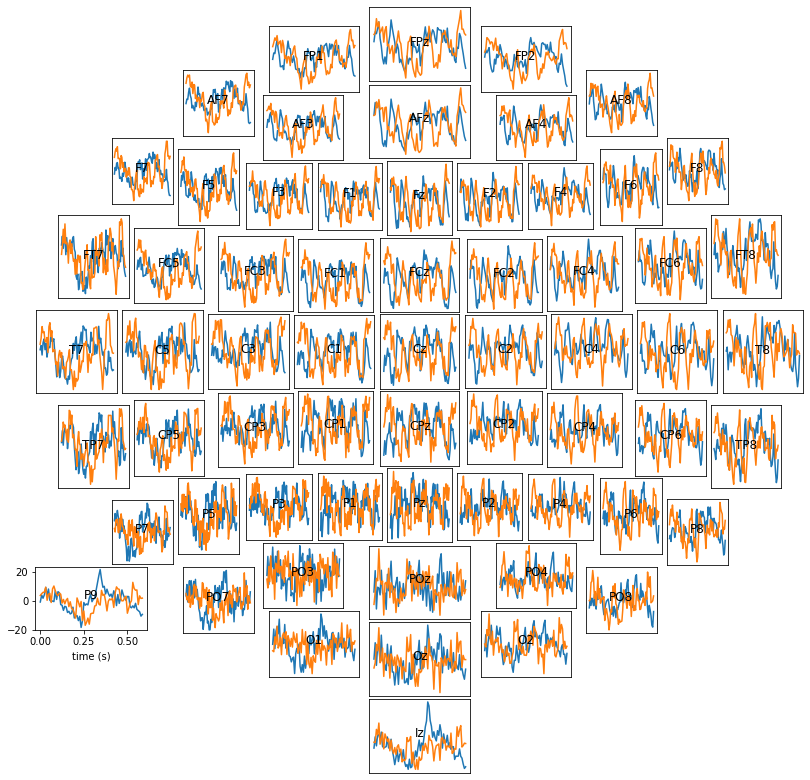

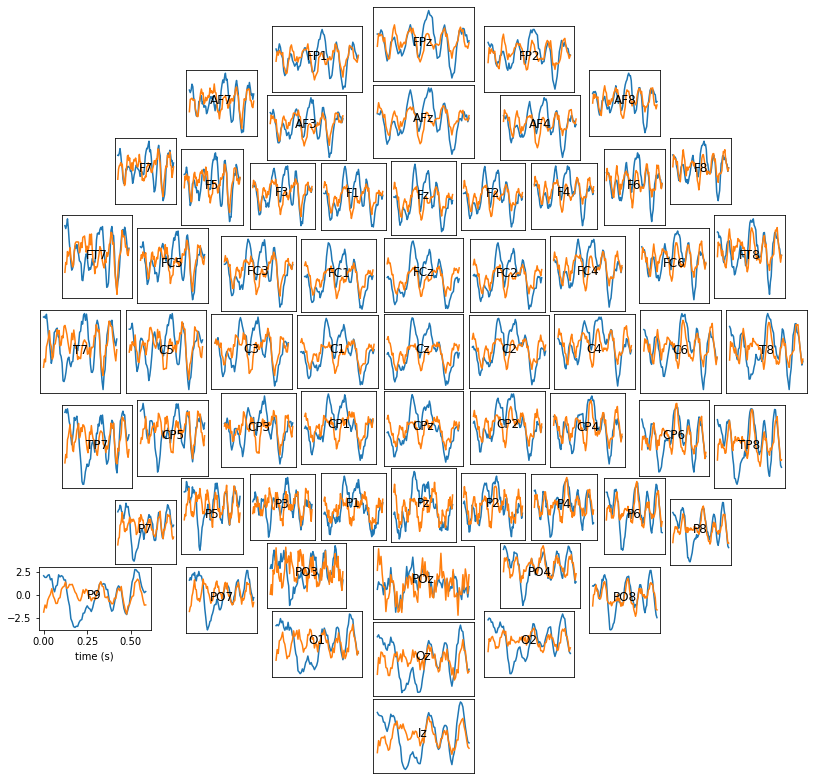

In [9]:
# 2: bad-channel removal
goodch, badch = preproc.outlierdetection(X);
X = X[goodch,:,:];
Cnames=Cnames[goodch];
Cpos=Cpos[:,goodch];
updatePlots()

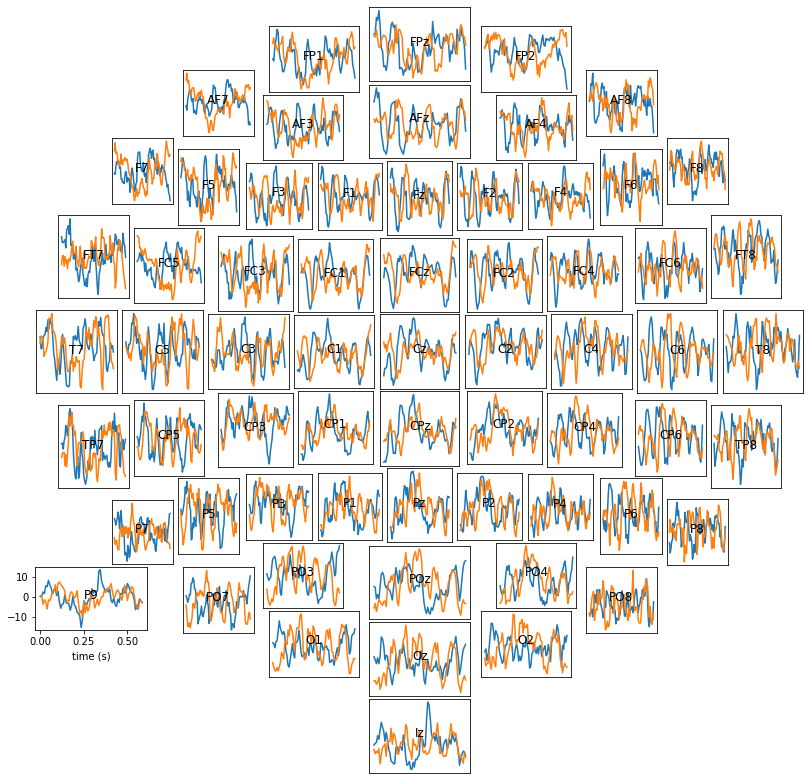

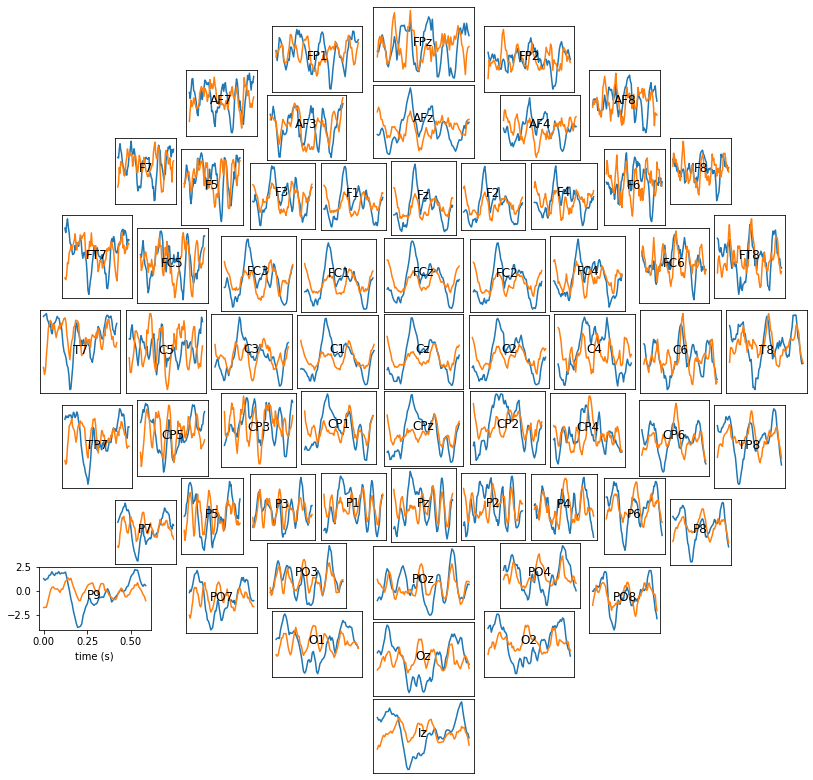

In [10]:
# 3: apply spatial filter
X        = preproc.spatialfilter(X,type='car')
updatePlots();

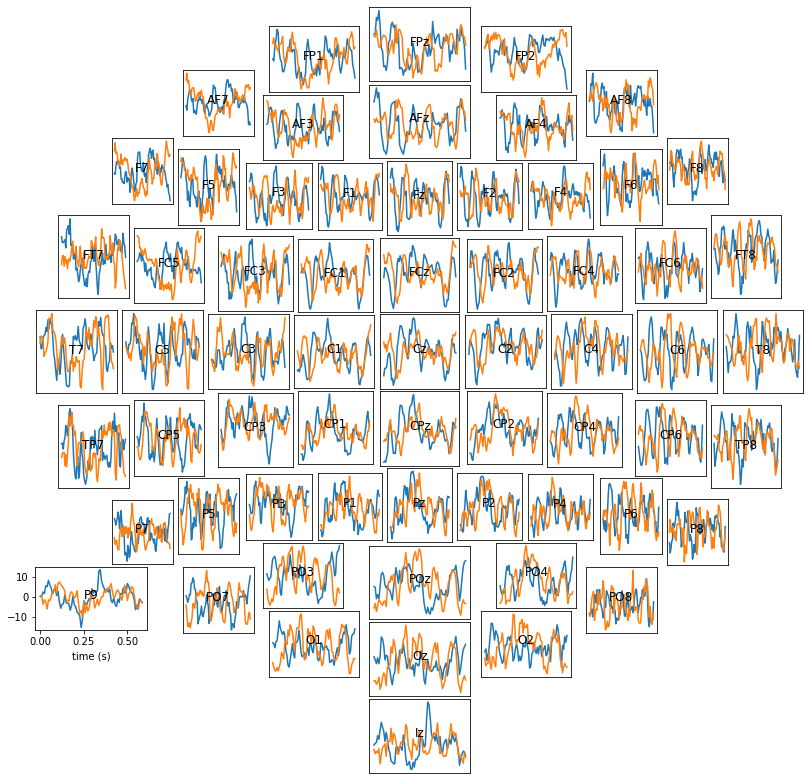

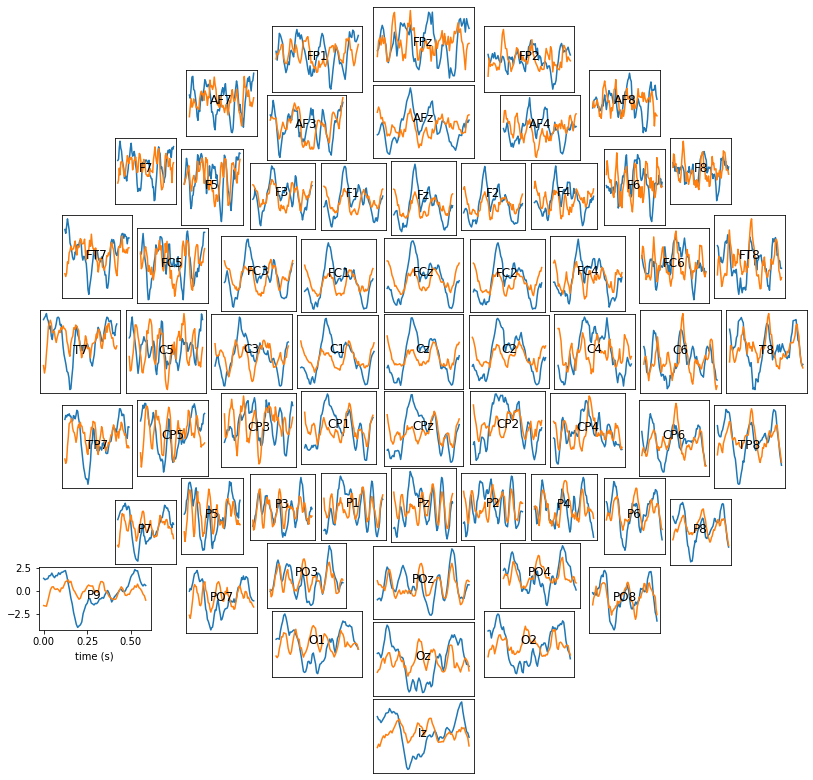

In [11]:
# 6 : bad-trial removal, trials in dim=2
goodtr, badtr = preproc.outlierdetection(X,dim=2)
X = X[:,:,goodtr]
Y = Y[goodtr]
updatePlots()

In [12]:
# 7: train linear least squares classifier, with cross-validation
import sklearn
clsfr = sklearn.linear_model.RidgeCV()
X2d = np.reshape(X,(-1,X.shape[2])).T # sklearn needs x to be [nTrials x nFeatures]
clsfr.fit(X2d,Y)
clsfr.score

<bound method RegressorMixin.score of RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)>

/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:880: MatplotlibDeprecationWarning: 
Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  message="Using pyplot.axes(ax) with ax an Axes "


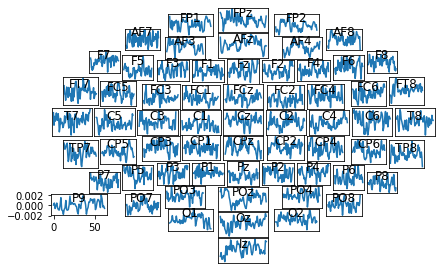

In [13]:
# plot the classifier weight vector
W = clsfr.coef_
W = np.reshape(clsfr.coef_,(X.shape[1],X.shape[0])) 
image3d(W,0,plotpos=Cpos,xvals=Cnames);